# Milestone 5: Baseline Model and Pipeline

__CS109B: Final Project__

__Due: May 8, 2024__

__Group 34:__ Bella Tarantino, Ethan Tran, Gabe LeBlanc, Hannah Boen

### Import Libraries

In [1]:
import librosa
import os
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Conv2D, MaxPooling2D
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import helpers

<a id="contents"></a>

## Table of Contents

1. [**Problem**](#p1)

2. [**Data Description and Handling**](#p2)
  
3. [**EDA**](#p3)

4. [**Modeling**](#p4)

5. [**Results**](#p5)


<a id="p1"></a>
    
## Problem

[Return to contents](#contents)

### Motivation, Context, and Framing

Man has, for ages, sought to understand our feline friends.  Communication barriers between humans and their domesticated pets lead to conflict, illness, and more. EDA revealed that there are differences in audio duration and waveform amplitude between certain classes of domestic cat sounds, encouraging a deeper exploration.  For example, the Fighting class call has peak amplitudes over 1.5 while the Resting class has a peak amplitude just over 0.2 . An algorithmic way to analyze the sentiment of domestic feline vocal activity could distinguish classes more precisely, and thus help: 

1. Improve human-animal communication, enhancing the way humans interact with and care for domestic cats
2. Veterinarians and other caretakers assess and identify pain, discomfort, and stress
3. Behavioral and linguistic research, in studying the impacts of domestication on communication

### Problem Statement

Our project question, formulated by examining our data and the various motivations above is: 

> ❓   How can we use deep learning to classify domestic cat emotions based on their vocal activity? 

<a id="p2"></a>
    
## Data Description and Handling

[Return to contents](#contents)

For our CS109B final project we will be classifying the sounds of domestic house cats using the Cat Sound Classification Dataset V2 curated by Yagya Raj Pandeya for their 2018 article, [“Domestic Cat Sound Classification Using Learned Features from Deep Neural Nets”](https://www.mdpi.com/2076-3417/8/10/1949) (Pandeya, Kim, and Lee 2018). This dataset contains about 2964 audio files (mp3) of cats making various noises categorized into 10 classes: angry, defense, fighting, happy, hunting mind, mating, mother call, paining, resting, and warning. Our project will primarily consist of training a machine learning model to identify and classify the audio of sounds made by domestic cats into one of these 10 classes.
   
These audio files can be utilized for machine learning after being transformed through a variety of preprocessing techniques. For instance, these mp3 audio files can be  transformed into spectrograms—visualizations of all frequencies layered together to generate a given sound. These images can be fed in as the input data of a convolutional neural network (CNN) for classification. Alternatively, these mp3 files can be transformed into Mel-frequency cepstrum coefficients, a numeric representation of the layered spectrum of frequencies composing a given sound. These coefficients can be fed as inputs into a conventional feed forward neural network or a recurrent neural network (RNN). However, before our raw mp3 files can be transformed into these forms, which are much more useful for the training of a classification model, we will load them as a floating point time series using the librosa package (documentation) and perform some general pre-processing.


In [2]:
# pre-defined classes present in data 
classifications= ['Angry', 'Defence', 'Fighting','Happy', 'HuntingMind', 'Mating', 
'MotherCall', 'Paining', 'Resting', 'Warning']

<a id="p3"></a>
    
## EDA

[Return to contents](#contents)

### Data Pipeline (Loading, Cleaning, Augmenting, Pickling)

`grab_data` is part of the pipeline to automate the process of loading, preprocessing, and augmenting our dataset. We make use of .pkl files for efficient loading of our data, and we trim and pad each audio file to account for varying lengths of waveforms. Using a subset of our overall dataset for computability reasons, we create test and train splits in the data. We use this data for EDA, and then apply data augmentation to produce the dataset used in modeling. 

We identify in our EDA that pitch is an important predictor that help differentiate between audio files, so we augment along that dimension using a small (random) pitch change for each waveform. For the same reason, we randomly add noise to each data point. We combine each of these augmented data frames with our original data frame, creating a dataset that is 3 times as large as the original. For differentiation later, we assign all augmented rows with a 1 in the "augmented" column and a 0 otherwise. 

While we had also identified speed as an important predictor, but augmenting the speed of each file (which often led to audio files over double their current length) proved to be computationally difficult due to memory usage.

Note: while the original dataset does include augmented files, we specifically exclude those and create our own augmented waves because we do not have information about how their files were augmented, and we want our model to be generalizable in terms of pitch and noise.

In [3]:
# grab a df of the cleaned data, un-mel-spectrogrammed
aug_data = helpers.grab_data()

Data found, loading contents...


After grabbing this data, we converted it and saved it to tensorflow datasets, giving us the following importations: 

In [4]:
# grab the mel data as tensor datasets 
train = tf.data.Dataset.load('./data/train')
validation = tf.data.Dataset.load('./data/validation')
test = tf.data.Dataset.load('./data/test')

Due to some issues with downloading the un-processed data, we will set a variable, `run`, equal to `False.` This will prevent running any cells for which content will be imported as images or from pickle files.

In [5]:
run = False

#### Sample Data Function

We perform EDA and feature engineering on a balanced sample of our data, for sake of visibility. Below is a function to create such a sample. This function, depending on whether the 'aug' parameter is set to True, can return either a sample of non-augmented data (allowing us to visualize the original, unmodified dataset) or a sample of the complete dataset with augmented and nonaugmented files (allowing us to visualize a smaller sample of the modified dataset for comparison). 

To see this function, please check `helpers.py`, `sample()`. 

### Feature Exploration




When inspecting the initial unprocessed and unaugmented data, we observe the audio files have different durations. To create a consistent model input, we trim leading zeros and pad as part of our data pipeline. Below are visualizations of audio duration across all sample files and by class prior to cleaning. 

The output of this code, when run, is the following:


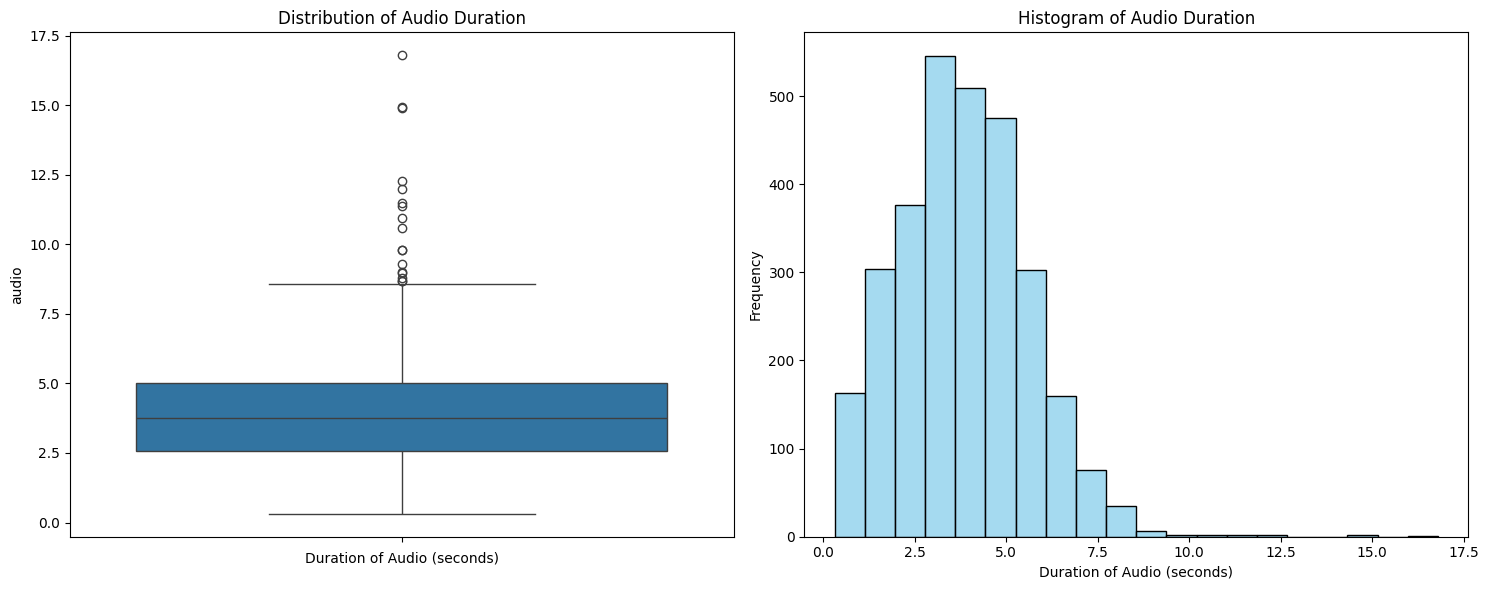


**Audio Duration Metrics (seconds):**

25% Quartile: 2.5861

Median: 3.7616

75% Quartile: 5.0155

Minimum: 0.3135

Maximum: 16.7967

In [6]:
if run == True:
    with open("data.pkl", "rb") as file:
        unprocessed_data, max_size = pickle.load(file)

    unprocessed_df = pd.DataFrame(unprocessed_data)

    # audio duration plots and metrics
    audio_durations = unprocessed_df['audio'].apply(lambda x: librosa.get_duration(y=x))

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # box plot for audio durations
    sns.boxplot(y=audio_durations, ax=axs[0])
    axs[0].set_xlabel('Duration of Audio (seconds)')
    axs[0].set_title('Distribution of Audio Duration')

    # histogram for audio durations
    sns.histplot(audio_durations, bins=20, color='skyblue', edgecolor='black', ax=axs[1])
    axs[1].set_xlabel('Duration of Audio (seconds)')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Audio Duration')

    # metrics for audio durations boxplot
    median_duration = np.median(audio_durations)
    Q1_duration = np.percentile(audio_durations, 25)
    Q3_duration = np.percentile(audio_durations, 75)
    whiskers_min_duration = np.min(audio_durations)
    whiskers_max_duration = np.max(audio_durations)

    print("Audio Duration Metrics (seconds):")
    print("25% Quartile:", np.round(Q1_duration, 4))
    print("Median:", np.round(median_duration, 4))
    print("75% Quartile:", np.round(Q3_duration, 4))
    print("Minimum:", np.round(whiskers_min_duration, 4))
    print("Maximum:", np.round(whiskers_max_duration, 4))

    plt.tight_layout()
    plt.show()

The output of the code below, when run, is:

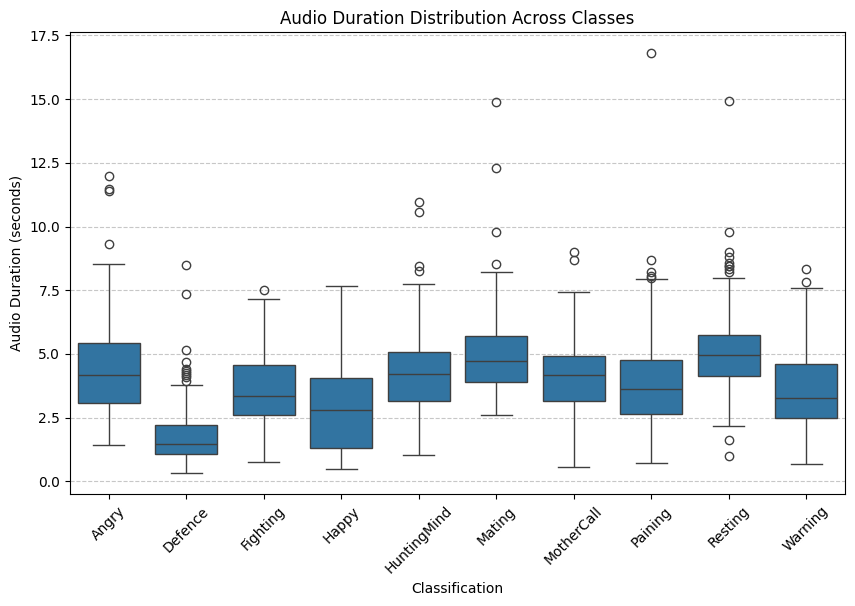


In [7]:
if run == True:
    # audio duration across classes
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='classification', y=audio_durations, data=unprocessed_df)
    plt.xlabel('Classification')
    plt.ylabel('Audio Duration (seconds)')
    plt.title('Audio Duration Distribution Across Classes')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

After cleaning the audio file data, the next task is to transform the data into features to be fed into our model. Since there are a number of audio features to consider, one goal of EDA is to determine which feature representation best distinguishes between classes. We investigate the following main audio features and representations: amplitude as waveforms, Fourier transformed frequency via spectrograms, and Mel Scale Spectrograms. This exploration is first conducted with a balanced random sample of our unaugmented data. 

Note that the following visualizations are created using cleaned data. Hence, some visualizations have padded zeros on the right side shown as straight lines in waveforms and black portions of spectrograms.  


#### Unaugmented EDA

In [8]:
sample_X_train, sample_X_test, sample_y_train, sample_y_test = helpers.sample(aug_data)
sample_df = pd.concat([sample_y_train, sample_X_train], axis=1)

We first represent the data in its original waveform by class. Since displaying every audiofile within a classification would be visually overwhelming (even from our sample), we generated a random set of 10 indices and plotted those 10 audiofiles within each class. 

We observe waveform differences between classes. For instance, the `Fighting` class call has peak amplitudes over 1.5 while the `Resting` class has a peak amplitude just over 0.2. This intuitively makes sense, as interactions involving aggression and distress will produce louder calls compared to resting. 


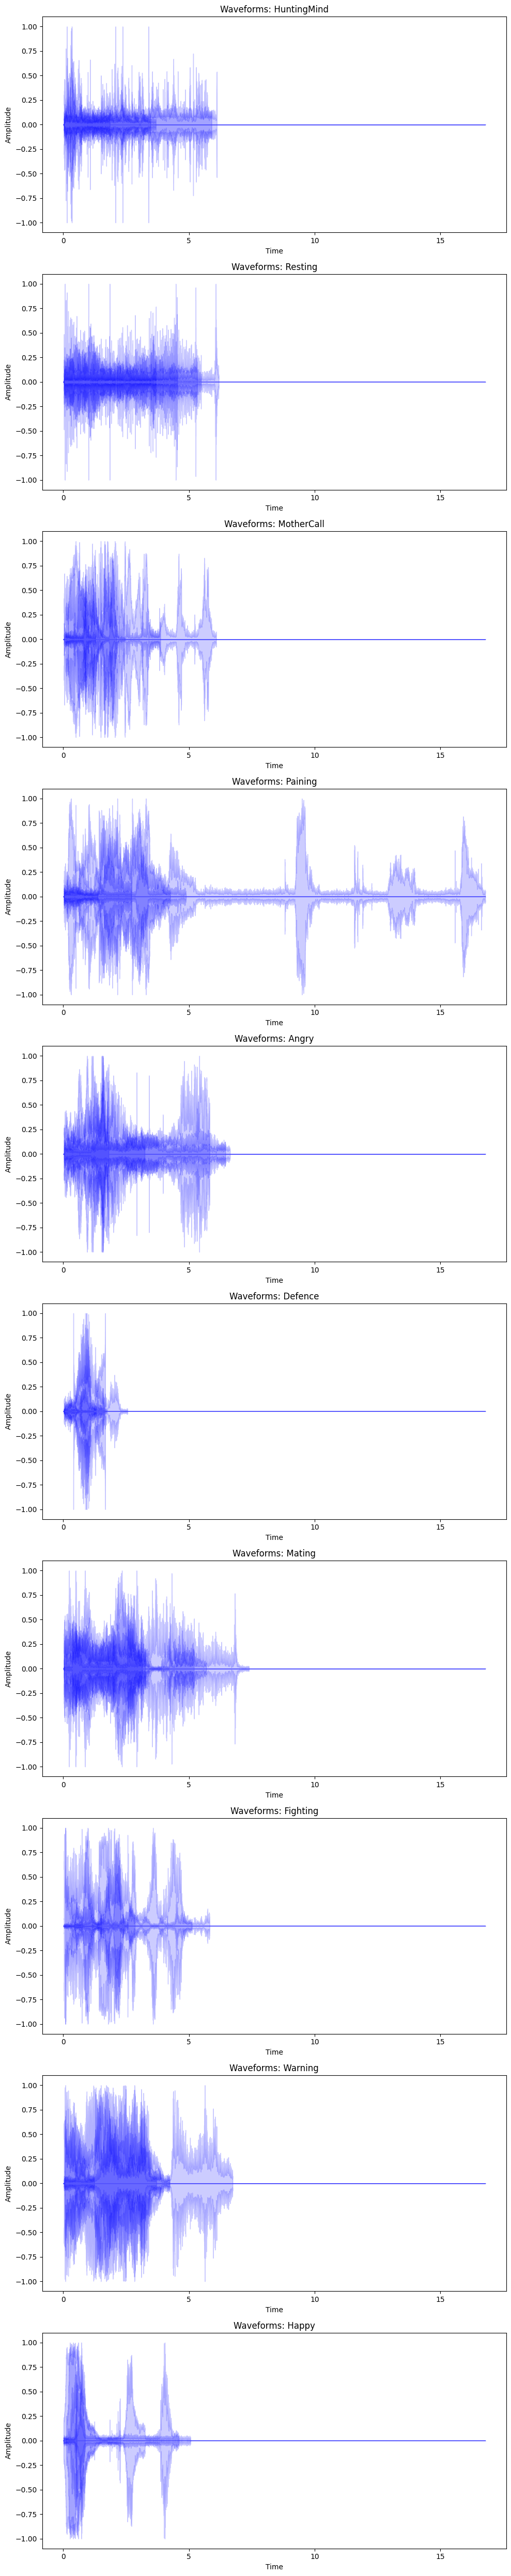

In [9]:
# waveforms across classes

num_classes = len(sample_df['classification'].unique())
class_counts = sample_df['classification'].value_counts()
smallest_class = class_counts.min()
indices = random.sample(range(smallest_class), 5)

# plot for each classification
fig, axs = plt.subplots(num_classes, figsize=(10, 5*num_classes))

for i, cls in enumerate(sample_df['classification'].unique()):
    # selecting random audio files from each class
    class_entries = sample_df[sample_df['classification'] == cls]['audio'].iloc[indices]
    
    # plot each audiofiles waveform in the subplot
    for audio in class_entries:
        librosa.display.waveshow(audio, ax=axs[i], color='b', alpha=.2)
    
    axs[i].set_title(f'Waveforms: {cls}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


The Fourier Transform is a common method for the decomposition of audio signals sampled in the time domain into a collection of component frequencies and their amplitudes in the frequency domain.  The Fourier transform generates a series of Fourier coefficients representing the contributions of each component frequency to the overall audio signal.  Our audio signals' contents do not stay consistent over their duration and vary over time.  This requires us to "window" our Fourier Transforms such that we decompose each varied segment of our audio signal into its component frequencies.  A common way of visualizing a single signal's frequencies over time is through a spectrogram.

Spectrograms are plots constructed with the results of Fourier Transforms.  As each Fourier Coefficient represents the amplitude contribution to a parent signal, we can overlay our calculated coefficients on a set of axes to visualize how our signal's amplitude varies over time at many different frequencies.  More specifically, spectrograms have time in seconds on the horizontal axis, frequency in Hertz on the vertical axis, and amplitude mapped to the fill color of the plot.  Now, while these completed spectrograms are fully suitable for analysis, the standard scale of frequencies (Hertz) do not adequately match the limitations of human hearing.  As a result, since we are analyzing differences in cat meows that could ostensibly be audible to the human ear, we must use an alternative scale.

Below is an example of a Fourier transformed spectrogram for one randomly selected audio file from each class. 

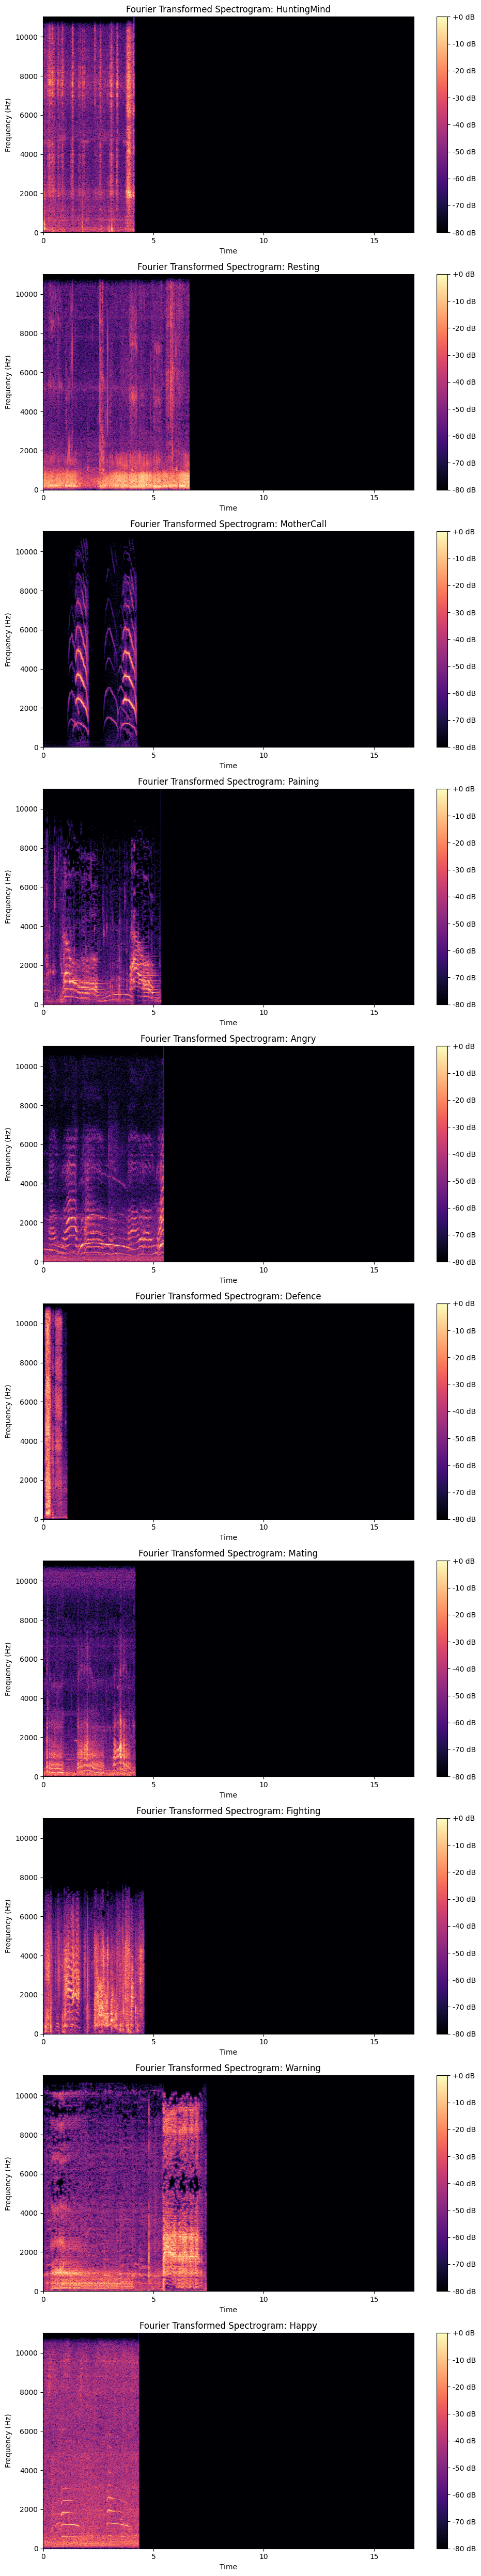

In [10]:
# fourier transformed spectrogram across classes

# generating random index
indices = random.sample(range(smallest_class), 1)

# plot for each classification
fig, axs = plt.subplots(num_classes, figsize=(10, 5*num_classes))

for i, cls in enumerate(sample_df['classification'].unique()):
    # selecting randomly indexed audio files from each class
    class_entries = sample_df[sample_df['classification'] == cls]['audio'].iloc[indices]
    
    # plot each audiofiles waveform in the subplot
    for audio in class_entries:
        D = librosa.stft(audio)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axs[i])
        fig.colorbar(img, ax=axs[i], format="%+2.f dB")
    
    axs[i].set_title(f'Fourier Transformed Spectrogram: {cls}')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_xlabel('Time')

plt.tight_layout()
plt.show()

We use the Mel Scale as an alternative scale. The Mel Scale is a perceptual scale for frequency under which identical distances in either direction of a given pitch will sound equally distant. This scale was motivated by the fact that humans can more easily tell lower frequencies apart than higher frequencies, thus necessitating larger jumps in Hz to achieve an equal difference in perceived pitch at higher frequencies. To utilize the Mel Scale, we will simply convert the vertical axes of our spectrograms into Mels rather than Hz, and perform multi-class classification on the generated spectrograms.

Below is an example of a Mel Scale spectrogram for a random audiofile from each class. We decide to use this representation of our data for several reasons. 

First and foremost, the Mel Scale Spectrogram representation is a logical choice based on domain knowledge.  When classifying emotions, it makes sense that the frequency components, which describe the pitch of the sound itself, would be a strong predictor.  If we were to use the original audio files and predict on those, normalized or not, we would be predicting on a function of the amplitude of the sound over time.  This does not provide us with direct information about the pitch.  

We saw many other benefits to using Mel Scale Spectrograms. For example, compared to predicting on the Fourier coefficients for the entire audio, of which there would be tens of thousands, we can predict on one, smaller image, saving us time and space when we convert the data from audio files to their Mel Spectrogram equivalents.  This was an issue we ran into in earlier stages, in which the Fourier Transformed data was too large, causing exponential increases in runtime and issues with storage. 

Similarly, by representing our data as Mel Spectrograms, we preemptively optimize the representation.  The features captured in the Mel Spectrogram may have taken extra resources for a model to learn on its own, which is information about the pitch and frequency.  By performing this step ourselves, we have converted our data to a more useful representation in advance, thus saving time and resources.

Even further, the final network architecture we utilize can likely be relatively simple due to the fact that the images we predict on will not require augmentation, have very simple features, etc.  This simplicity saves us computational resources and, thus, penguins. 

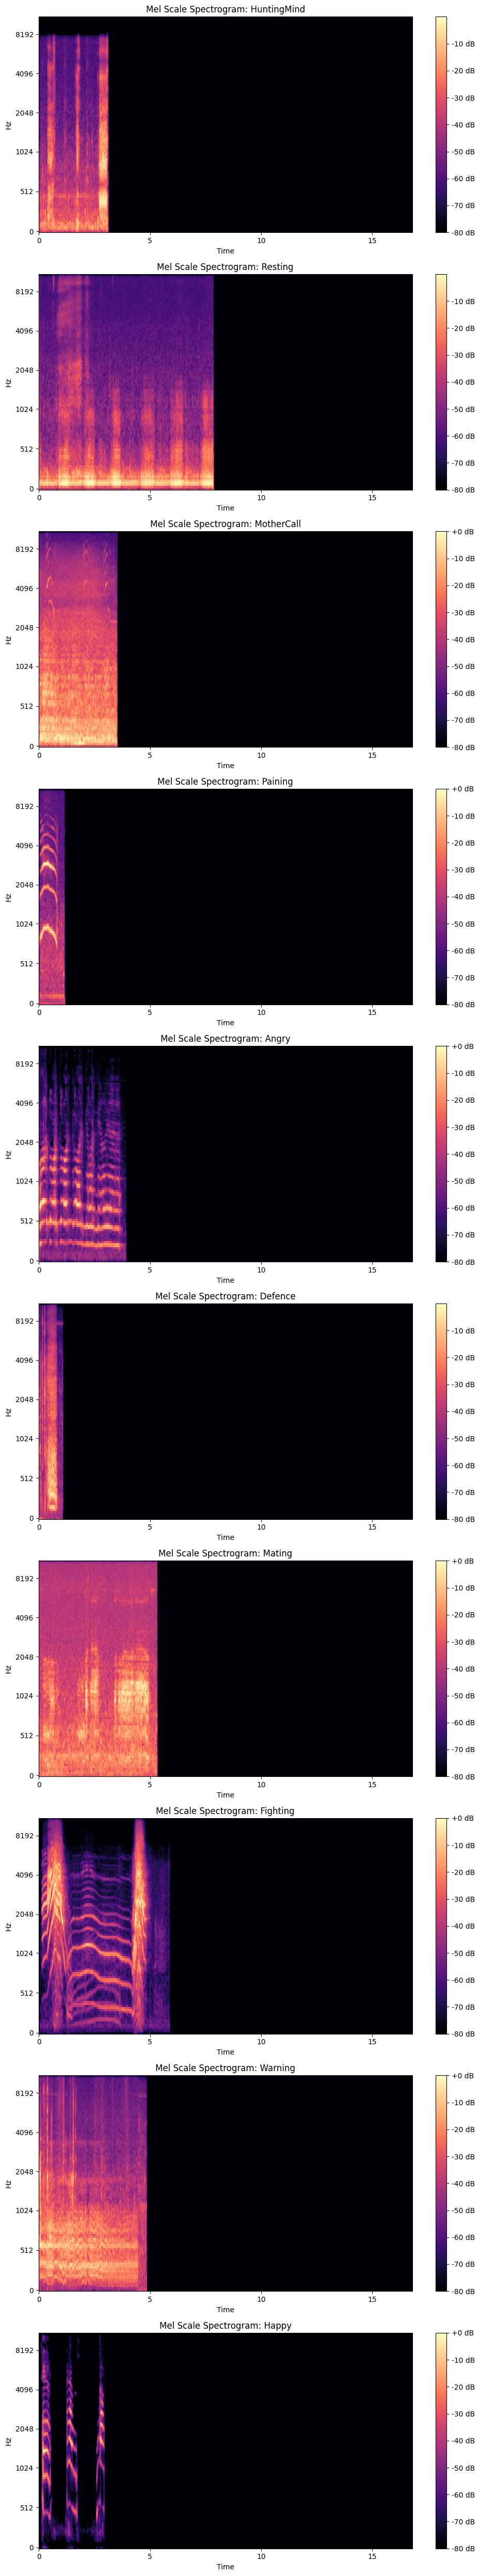

In [11]:
# mel scale spectrogram across classes
sr = 22050

# generating random index
indices = random.sample(range(smallest_class), 1)

# plot for each classification
fig, axs = plt.subplots(num_classes, figsize=(10, 5*num_classes))

for i, cls in enumerate(sample_df['classification'].unique()):
    # selecting randomly indexed audio files from each class
    class_entries = sample_df[sample_df['classification'] == cls]['audio'].iloc[indices]
    
    # plot each audiofiles waveform in the subplot
    for audio in class_entries:
        # compute the spectrogram
        spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=sr), ref=np.max)

        img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', sr=sr, ax=axs[i])
        fig.colorbar(img, ax=axs[i], format="%+2.f dB")

    axs[i].set_title(f'Mel Scale Spectrogram: {cls}')
    
plt.tight_layout()
plt.show()

#### Augmented EDA

Now that we have determined which representation of our data to use, we must decide whether or not to use augmented data in our model. While Mel Scale spectrograms are best for our model, we include waveforms of augmented data below for easy visual comparison between unaugmented data and data that includes augmented files, which we will refer to as augmented data. 

We see an increase in noise and greater variation in amplitude in our augmented data but a similar trend to out unaugmented data. We decide to include augmented data in our model to improve generalizability. 


In [12]:
aug_sample_X_train, aug_sample_X_test, aug_sample_y_train, aug_sample_y_test = helpers.sample(aug_data, aug=True)
aug_sample_df = pd.concat([aug_sample_y_train, aug_sample_X_train], axis=1)

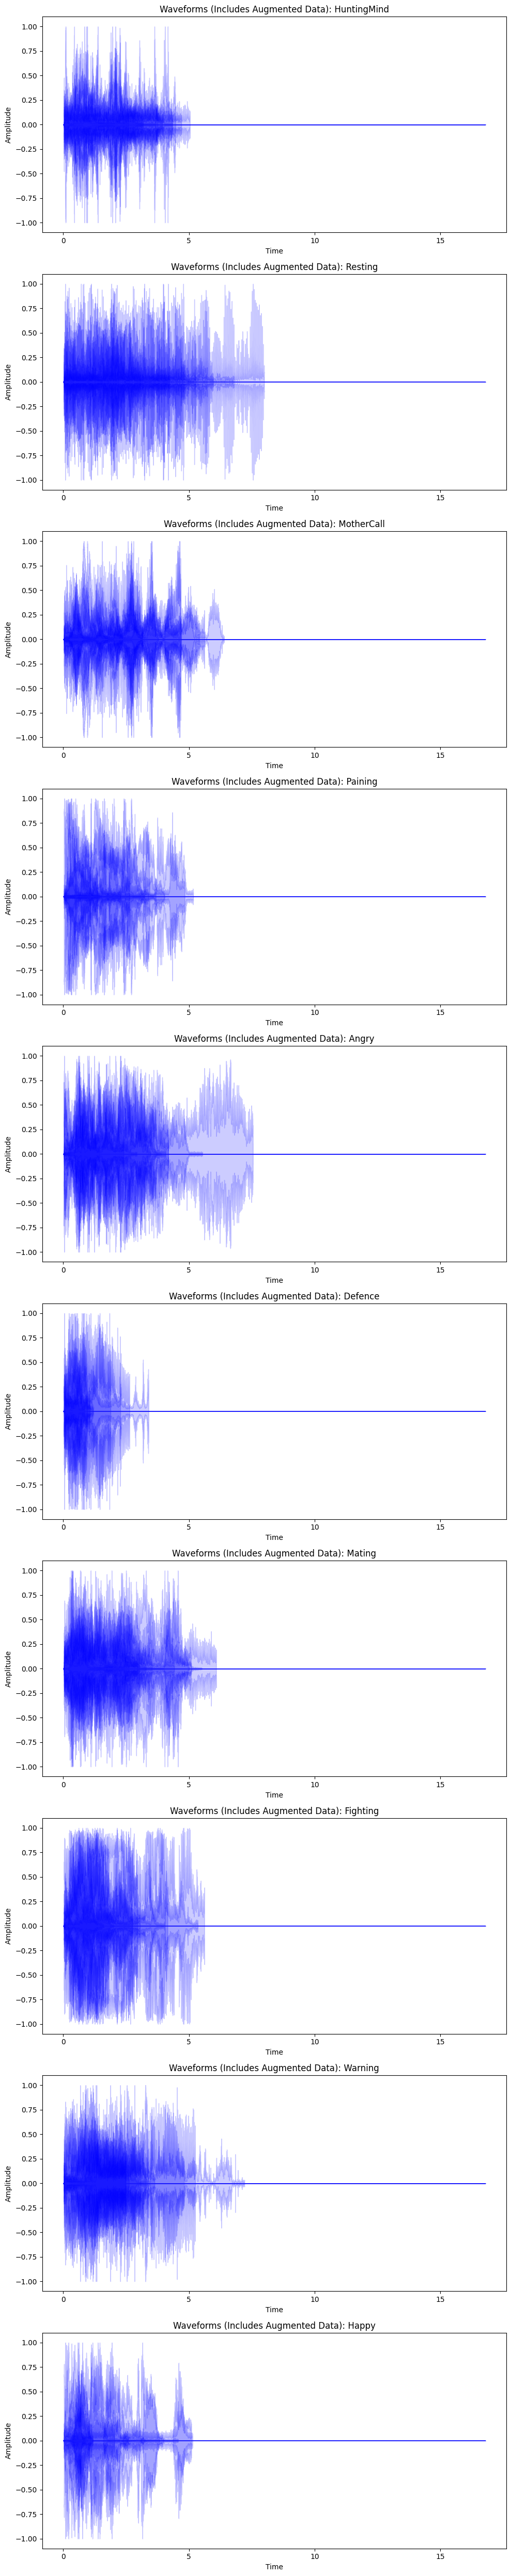

In [13]:
# waveforms across classes

num_classes = len(aug_sample_df['classification'].unique())
class_counts = aug_sample_df['classification'].value_counts()
smallest_class = class_counts.min()
indices = random.sample(range(smallest_class), 10)

# plot for each classification
fig, axs = plt.subplots(num_classes, figsize=(10, 5*num_classes))

for i, cls in enumerate(aug_sample_df['classification'].unique()):
    # selecting random audio files from each class
    class_entries = aug_sample_df[aug_sample_df['classification'] == cls]['audio'].iloc[indices]
    
    # plot each audiofiles waveform in the subplot
    for audio in class_entries:
        librosa.display.waveshow(audio, ax=axs[i], color='b', alpha=.2)
    
    axs[i].set_title(f'Waveforms (Includes Augmented Data): {cls}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


<a id="p4"></a>
    
## Modeling

[Return to contents](#contents)

### Model Flow Chart

![](./images/meow_flow_chart.png)

Having completed our data pipeline and EDA, we now explore the optimal deep learning model for classifying our cat vocalizations. As we have chosen to convert our raw audio data into processed spectrogram images, we have altered our input data shape from a single stream of amplitude values to a 2D array of pixel values. As result, our final model will be a Convolutional Neural Network (CNN) which will include:

- Convolutional Layers. Ideally, we will have multiple convolutional layers, the parameters of which we will tune.

- Pooling Layers.  We will make use of pooling, but we may choose to use an alternate method from MaxPooling which may suit our task better.  This is another factor to consider and potentially tune using cross-validation.

- Dense Layers.  We will make use of dense layers, the number of nodes of which have yet to be determined.  Similarly, we may choose to include dropout layers, depending on the generalizability of our final model.

- Transfer and Representation Learning.  To help learn prominent features of the Mel Frequency Spectrograms, we could consider using models trained on other musical or speech datasets containing features that are similar to those in our Cat Sounds Dataset.

### Baseline Model and Model Engineering

Before we attempt to construct our final model however, we had to test the quality of our selected prediction feature and our data pipeline by constructing an initial baseline CNN. To this end, we define several additional helper functions. The first, mel_spectrogram, converts our augmented audio data into Mel Scale Spectrograms using the librosa package's librosa.feature.melspectrogram function. We then transform their corresponding classifications into a set of 10 one-hot encoded vectors suitable for use with a Sparse Categorical Loss function. This additional preprocessing is combined with the mel_spectrogram, function in the mel_transform function. 

When creating spectrograms, there are several parameters that can be altered to receive alternative spectrograms for a given piece of audio, including:

- `sr`, the sampling rate, which indicates the samples of audio data taken per second for that specific piece of audio, usually measured in Hertz (Hz).

- `n_fft`, the number of Fast Fourier points used when converting the audio amplitudes to frequency, also known as the length of the FFT window, determines the resolution of the frequency created from the original waveform information. Small values will reduce dimensionality as there will be bigger "gaps" between windows while larger values will increase resolution but decrease time resolution as windows will be longer and take less "time" to fully convert all sampled points at least once.

- `n_mel`, the number of Mel Frequency Bands our frequency axis is separated into once they are converted from original waveform amplitude data. As the Mel scale is a perceptual scale this value can be interpreted as the number of bins of frequencies that sound equally far apart that our data will be sliced into.

- `hop_length`, the number of samples between successive frames, is similar to the value of n_fft in that as it grows the dimensionality of our resulting spectrogram will decrease as the frequency axis will be converted into fewer Mel Scale windows.

For our model, we decided to keep our sampling rate static as all of our original data was sampled at a conventional 22050 Hz. Similarly, we decided to keep the number of FFT points and the number of Mel Frequency Bands static to ensure a uniform level of resolution in our frequency axis. Upon initial testing however, the dimensionality of our resulting spectrograms was quite large and to test whether or not smaller or larger spectrograms would reduce training times, computational needs, and validation loss we experimented with alternative values for hop_length. Conventionally, hop lengths are multiples of the number of Mel Frequency Bands, therefore, we created a new hop_length_mult parameter for our mel_spectrogram and mel_transform functions that n_mels will be multiplied by to set our value for hop_length. 

As the tuning of hop_length would return spectrograms of different dimensions, we needed to programmatically generate models that followed our baseline architecture but accepted each alternate input shape. So, we defined the mel_modele function which initializes a basic model of ReLU activated layers, starting with two 3x3 kernel convolutional layers with 32 and 64 filters, respectively, each followed by 2x2 max pooling, a single dense layer of 128 neurons, and a final 10 neuron output with a softmax activation function. The model is then compiled using the Adam optimizer with default tensorflow parameters and categorical cross entropy loss function.

Having defined these functions, we then create X and y train and test data using our sample of our original cat meow dataset for hop lengths equal to 4, 2, and 1 times our number of Mel Frequency Bands, which is set to 128. 

In [14]:
# prepare data with different hop_lengths
# hop length = 128 * 4 = 512 mel
sample_X_train_4, sample_y_train_4 = helpers.mel_transform(sample_X_train, sample_y_train, 4)
sample_X_test_4, sample_y_test_4 = helpers.mel_transform(sample_X_test, sample_y_test, 4)

# hop length = 128 * 2 = 256 mel
sample_X_train_2, sample_y_train_2 = helpers.mel_transform(sample_X_train, sample_y_train, 2)
sample_X_test_2, sample_y_test_2 = helpers.mel_transform(sample_X_test, sample_y_test, 2)

# hop length = 128 * 1 = 128 mel
sample_X_train_1, sample_y_train_1 = helpers.mel_transform(sample_X_train, sample_y_train, 1)
sample_X_test_1, sample_y_test_1 = helpers.mel_transform(sample_X_test, sample_y_test, 1)

creating spectrograms
4.2001051902771 ms
hot encoding
0.0 ms
converting to tensor
0.04982471466064453 ms
creating spectrograms
1.1998753547668457 ms
hot encoding
0.0 ms
converting to tensor
0.016787052154541016 ms
creating spectrograms
7.353844165802002 ms
hot encoding
0.0 ms
converting to tensor
0.08021950721740723 ms
creating spectrograms
1.8336033821105957 ms
hot encoding
0.0 ms
converting to tensor
0.016399145126342773 ms
creating spectrograms
13.41557788848877 ms
hot encoding
0.015720844268798828 ms
converting to tensor
0.25235438346862793 ms
creating spectrograms
3.3067145347595215 ms
hot encoding
0.0 ms
converting to tensor
0.02956557273864746 ms


In [15]:
# Print resulting dimensions of spectrograms generated for each value of hop_length
print(f"Varied Hop Length Spectrogram dimensions:\n\nHop Length 4:\t{sample_X_train_4.shape}\nHop Length 2:\t{sample_X_train_2.shape}\nHop Length 1:\t{sample_X_train_1.shape}")

Varied Hop Length Spectrogram dimensions:

Hop Length 4:	(200, 128, 724, 1)
Hop Length 2:	(200, 128, 1447, 1)
Hop Length 1:	(200, 128, 2894, 1)


In [16]:
len_4_model = helpers.mel_model(sample_X_train_4.shape[1:])

len_2_model = helpers.mel_model(sample_X_train_2.shape[1:])

len_1_model = helpers.mel_model(sample_X_train_1.shape[1:])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 722, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 361, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 359, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 179, 64)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 343680)            0         
                                                                 
 dense (Dense)               (None, 128)              

We next fit each of our models on their respective training data sets and evaluate them on our test datasets. We train each model for 3 epochs with a batch size of 2 due to computational resource constraints before training a Mel Model on our entire training data set, saving its weights for later evaluation.

In [17]:
model_histories = []

x_trains = [sample_X_train_4, sample_X_train_2, sample_X_train_1]
y_trains = [sample_y_train_4, sample_y_train_2, sample_y_train_1]
x_tests = [sample_X_test_4, sample_X_test_2, sample_X_test_1]
y_tests = [sample_y_test_4, sample_y_test_2, sample_y_test_1]

for i, model in enumerate([len_4_model, len_2_model, len_1_model]):

    print(f"Training Model on Hop Length {i}")
    model_histories.append(model.fit(x_trains[i], 
                    y_trains[i], 
                    validation_data=(x_tests[i], y_tests[i]),
                    epochs=3,
                    batch_size=2,
                    verbose = 0))

Training Model on Hop Length 0


Training Model on Hop Length 1
Training Model on Hop Length 2


### Visualizing Baseline Model Performance

To best visualize our models' performances, we define a plot_performance function that generates a plot of the model's Training Accuracy, Validation Accuracy, Training Loss, and Validation Loss over training epochs.

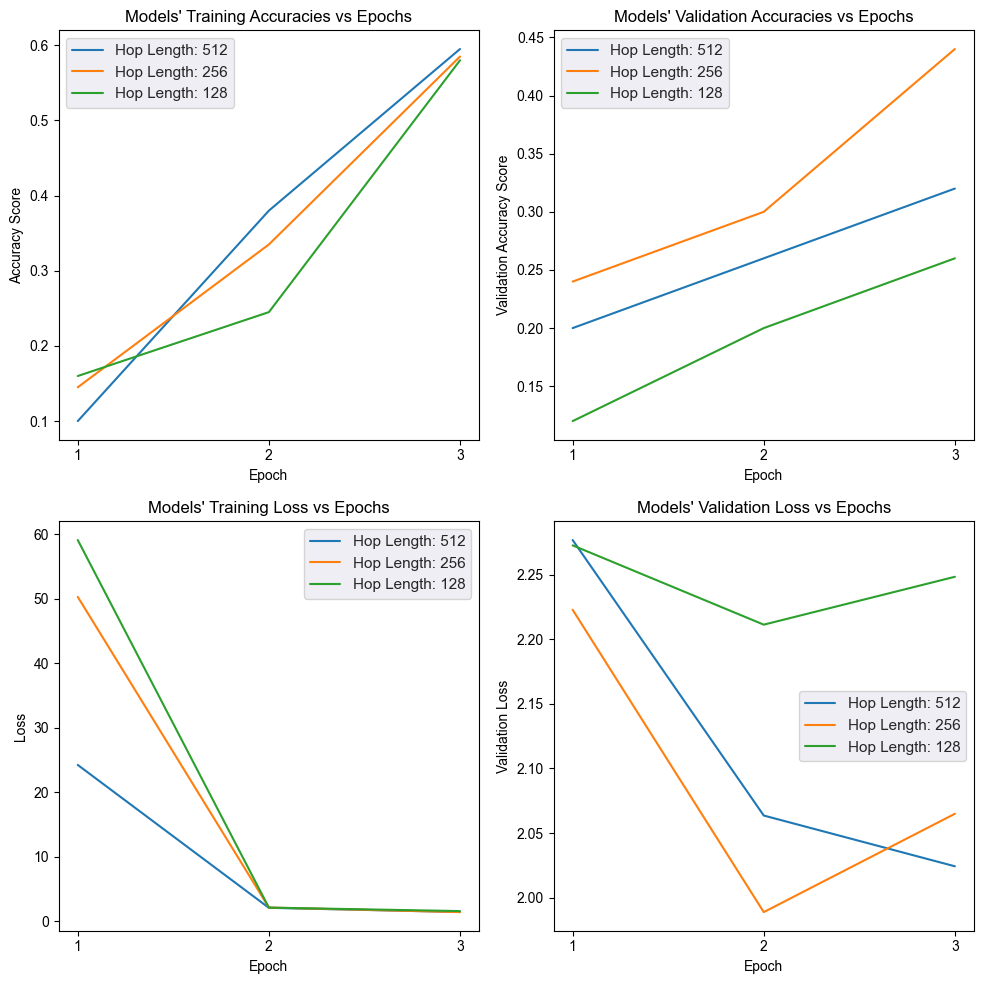

In [18]:
helpers.plot_performance(model_histories)

As can be seen, the model with the hop length set as four times the number of mel frequency bands achieves the lowest validation loss and highest validation accuracy score when trained on a sample of our total unaugmented data set and thus is the best of the three different choices for `hop_length_mult`.  This is reflected in the final `train`, `test`, and `validation` datasets we load, which contain the mel spectrograms as `tf` datasets. Thus, we can load our baseline model, its history, and performance: 

In [19]:
baseline = tf.keras.models.load_model('./models/Baseline')
baseline_history = pickle.load(open('./histories/Baseline.pkl', 'rb'))

...which had an accuracy of 0.85.

### Baseline Transfer Learning Model

Having achieved a relative level of success with our baseline CNN architecture, we moved to attempt transfer learning from pre-trained Hugging Face models. The model architecture that we decided to utilize was the iconic VGG16 created by Karen Simonyan and Andrew Zisserman in 2014 for the ImageNet contest. Containing 16 layers with a total of 138 million parameters, VGG16 was a powerful model for image classification tasks. To evaluate the efficacy of VGG16 on our particular task, we first created a baseline transfer learning model.

This baseline transfer learning model consists of the frozen VGG16 layers and weights as well as an additional dense layer containing 512 neurons followed by a Dropout layer with a dropout rate of 0.5, and then a final 10 neuron output with a softmax activation function. This model is compiled with the default tensorflow Adam optimizer and sparse categorical crossentropy loss.

In [20]:
# show the architecture of the vgg model 
helpers.vgg()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 724, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 724, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 724, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 362, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 362, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 362, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 181, 128)      0     

In [21]:
# load the trained baseline model 
baseline_vgg = tf.keras.models.load_model('./models/BaselineVGG')
baseline_vgg_history = pickle.load(open('./histories/BaselineVGG.pkl', 'rb'))

This model was then trained for 10 epochs and achieved a final validation loss of: 0.3663 and validation accuracy of: 0.9061.

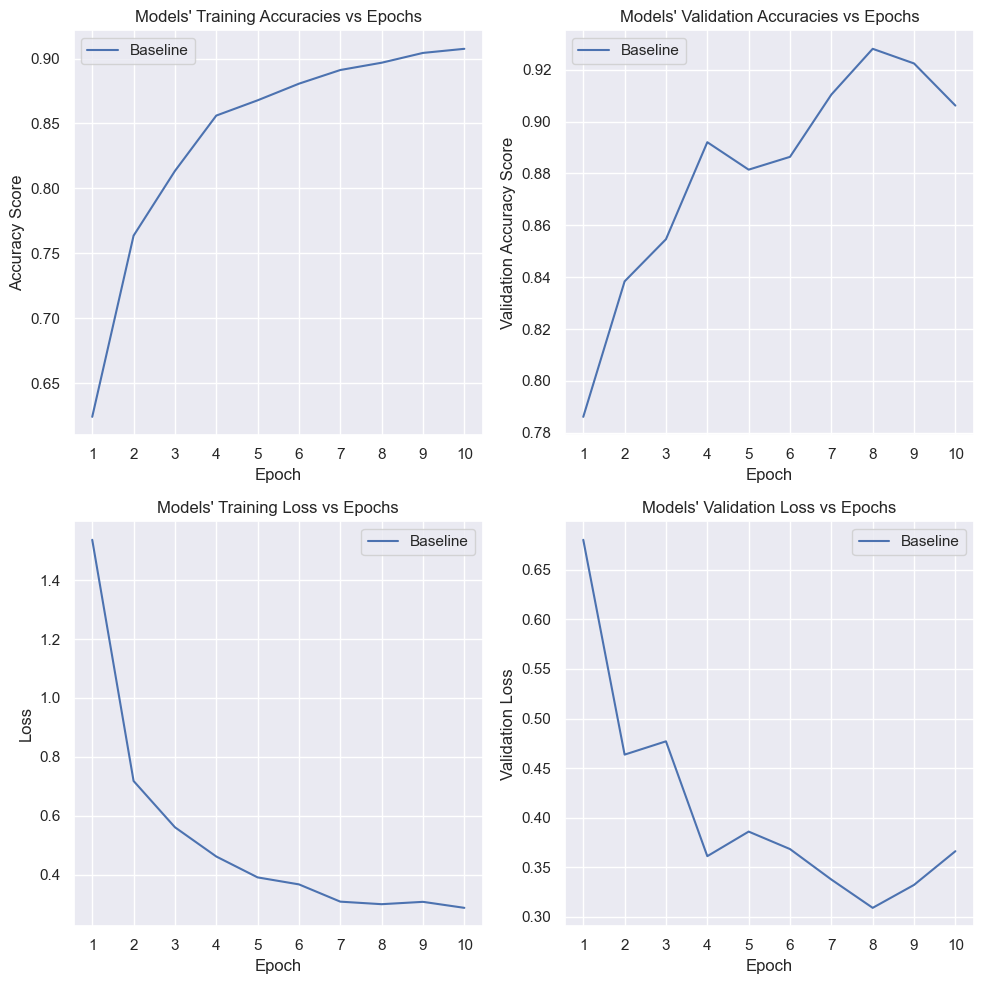

In [22]:
# plot Performance of Baseline VGG Model
helpers.plot_performance([baseline_vgg_history], False)

### Tuned Transfer Learning Model 

While we achieved respectable validation accuracy and validation loss scores with our baseline transfer learning model, we further refined our model through several different methods:

- Early Stopping. Implemented a standard tensorflow early stopping callback with patience set to 3 epochs  

- Decaying Learning Rate. Implemented a tensorflow LearningRateScheduler callback that decayed the learning rate after 1 warmup epoch

- Neuron Count for Penultimate Dense Layer. We evaluated the validation accuracy and loss for models with 64, 128, 256, 512, and 1024 neurons in their penultimate dense layer, discovering that 512 neurons yielded the best performance. 

- Dropout Rates. We evaluated the validation accuracy and loss for models with final dropout layer dropout rates of 0.1, 0.2, 0.3, 0.4, 0.5, discovering that a dropout rate of 0.2 yielded the best performance.

We performed this in TWO different models. In the first, we implemented only early stopping and a decaying learning rate, called `vgg_regularized`.  In the second, we combined this with a tuned number of nodes and dropout rate, called `best_model`.

In [23]:
# load the trained baseline model 
vgg_regularized = tf.keras.models.load_model('./models/RegularizedVGG')
vgg_regularized_history = pickle.load(open('./histories/RegularizedVGG.pkl', 'rb'))

The tuning was performed as such: 

In [24]:
if run == True:
    # tune the number of nodes
    node_histories = []
    for nodes in [64, 128, 256, 512, 1024]:
        model = helpers.vgg(nodes=nodes)
        model_hist = model.fit(train,
                                epochs=2,
                                validation_data=validation,
                                verbose=1)
        node_histories.append(model_hist.history['val_accuracy'])

    best_nodes, _ = np.unravel_index(np.argmax(node_histories), np.array(node_histories).shape)
    best_nodes = 2**(best_nodes + 6)
    print(f'Best Number of Nodes: {best_nodes}')

    dropout_histories = []

    # tune the number of dropouts
    for dropout in [0.1, 0.2, 0.3, 0.4, 0.5]:
        model = helpers.vgg(nodes=best_nodes, dropout=dropout)
        model_hist = model.fit(train,
                                epochs=2,
                                validation_data=validation,
                                verbose=1)
        dropout_histories.append(model_hist.history['val_accuracy'])

    best_dropout, _ = np.unravel_index(np.argmax(dropout_histories), np.array(dropout_histories).shape)
    best_dropout = (best_dropout+1)/10
    print(f'Best Dropout Rate: {best_dropout}')

But since it was run separately, we can simply attach the results we achieved. Below are the validation accuracies found in the training process: 

In [25]:
node_history, dropout_history = pickle.load(open('./histories/Tuning.pkl', 'rb'))

In [26]:
for i in range(len(node_history)):
    print(f'Validation accuracy with {2**(i+6)} nodes: {node_history[i][1]}')

print("")
print("")
for i in range(len(dropout_history)):
    print(f'Validation accuracy with {(i+1)/10} dropout rate: {dropout_history[i][1]}')

Validation accuracy with 64 nodes: 0.6393789649009705
Validation accuracy with 128 nodes: 0.7784050703048706
Validation accuracy with 256 nodes: 0.8009880185127258
Validation accuracy with 512 nodes: 0.843330979347229
Validation accuracy with 1024 nodes: 0.8440366983413696


Validation accuracy with 0.1 dropout rate: 0.858856737613678
Validation accuracy with 0.2 dropout rate: 0.8906139731407166
Validation accuracy with 0.3 dropout rate: 0.853210985660553
Validation accuracy with 0.4 dropout rate: 0.8546224236488342
Validation accuracy with 0.5 dropout rate: 0.822159469127655


As such, we instantiated `best_model`, which had 512 nodes in the second to last dense layer and a dropout rate of `0.2`.

In [27]:
# load the trained baseline model 
best_model = tf.keras.models.load_model('./models/BestModel')
best_history = pickle.load(open('./histories/BestModel.pkl', 'rb'))

After finishing our tuning, our finalized transfer learning model performed excellently, achieving a final validation accuracy score of: 0.959 with a validation loss of: 0.174.

### Comparing Models

In [28]:
histories = [baseline_history, baseline_vgg_history, vgg_regularized_history, best_history]

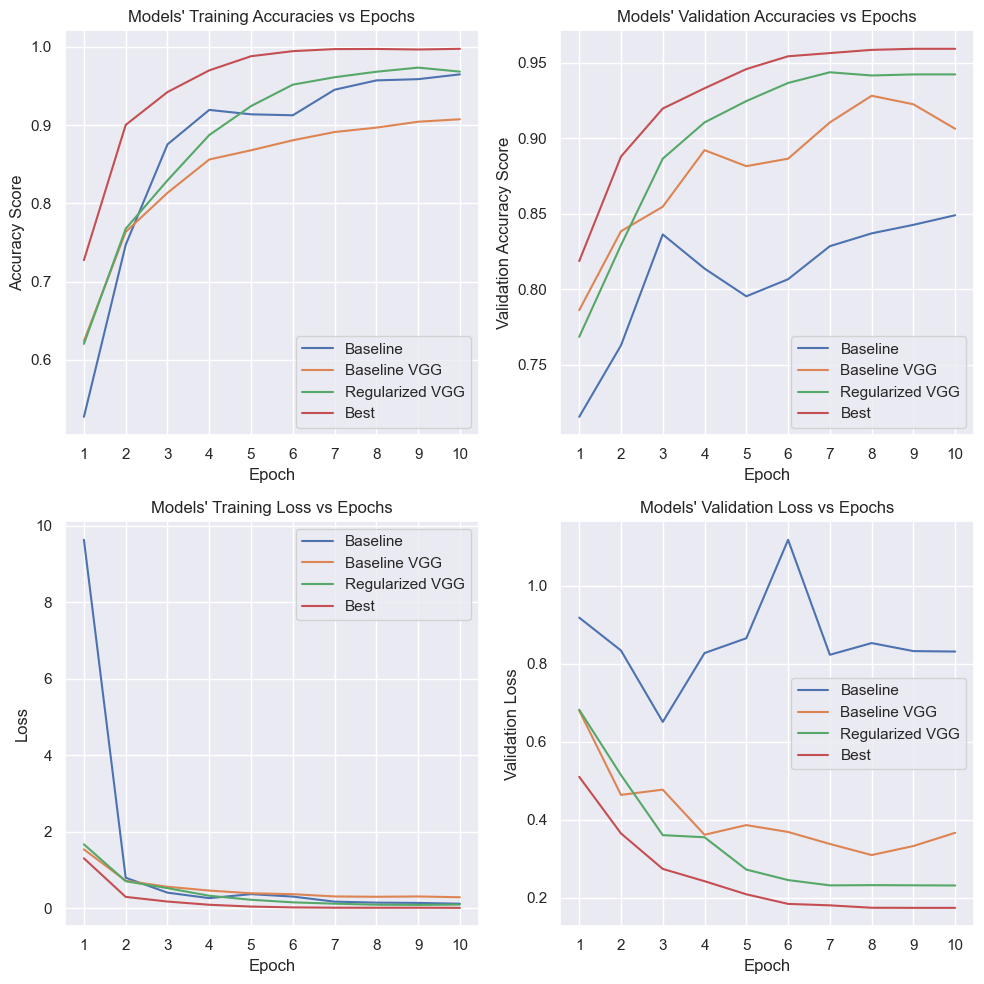

In [29]:
helpers.plot_performance(histories, False)

...and we can display the test and validation accuracies. Again, the code below required GPU, which we did not run the final notebook on, so we provide the results from when these models were evaluated on a GPU: 

In [30]:
if run:
    print("Baseline Model Test Accuracy: " + str(np.round(baseline.evaluate(test)[1], 2)))
    print("Baseline VGG Model Test Accuracy: " + str(np.round(baseline_vgg.evaluate(test)[1], 2)))
    print("Regularized VGG Test Accuracy: " + str(np.round(vgg_regularized.evaluate(test)[1], 2)))
    print("Regularized + Tuned VGG Test Accuracy: " + str(np.round(best_model.evaluate(test)[1], 2)))

else:
    print("Showing imported results...")
    print("112/112 [==============================] - 3s 23ms/step - loss: 0.6751 - accuracy: 0.8578")
    print("        Baseline Model Test Accuracy: 0.86")
    print("112/112 [==============================] - 3s 23ms/step - loss: 0.3336 - accuracy: 0.9056")
    print("        Baseline VGG Model Test Accuracy: 0.91")
    print("112/112 [==============================] - 3s 23ms/step - loss: 0.1825 - accuracy: 0.9483")
    print("        Regularized VGG Test Accuracy: 0.95")
    print("112/112 [==============================] - 3s 22ms/step - loss: 0.1330 - accuracy: 0.9640")
    print("        Regularized + Tuned VGG Test Accuracy: 0.96")


Showing imported results...
112/112 [==============================] - 3s 23ms/step - loss: 0.6751 - accuracy: 0.8578
        Baseline Model Test Accuracy: 0.86
112/112 [==============================] - 3s 23ms/step - loss: 0.3336 - accuracy: 0.9056
        Baseline VGG Model Test Accuracy: 0.91
112/112 [==============================] - 3s 23ms/step - loss: 0.1825 - accuracy: 0.9483
        Regularized VGG Test Accuracy: 0.95
112/112 [==============================] - 3s 22ms/step - loss: 0.1330 - accuracy: 0.9640
        Regularized + Tuned VGG Test Accuracy: 0.96


In [31]:
if run:
    print("Baseline Model Validation Accuracy: " + str(np.round(baseline.evaluate(validation)[1], 2)))
    print("Baseline VGG Model Validation Accuracy: " + str(np.round(baseline_vgg.evaluate(validation)[1], 2)))
    print("Regularized VGG Validation Accuracy: " + str(np.round(vgg_regularized.evaluate(validation)[1], 2)))
    print("Regularized + Tuned VGG Validation Accuracy: " + str(np.round(best_model.evaluate(validation)[1], 2)))

else:
    print("Showing imported results...")
    print("89/89 [==============================] - 2s 23ms/step - loss: 0.8316 - accuracy: 0.8490")
    print("        Baseline Model Validation Accuracy: 0.85")
    print("89/89 [==============================] - 2s 23ms/step - loss: 0.3663 - accuracy: 0.9061")
    print("        Baseline VGG Model Validation Accuracy: 0.91")
    print("89/89 [==============================] - 2s 23ms/step - loss: 0.2314 - accuracy: 0.9435")
    print("        Regularized VGG Validation Accuracy: 0.94")
    print("89/89 [==============================] - 2s 24ms/step - loss: 0.1737 - accuracy: 0.9591")
    print("        Regularized + Tuned Validation Test Accuracy: 0.96")


Showing imported results...
89/89 [==============================] - 2s 23ms/step - loss: 0.8316 - accuracy: 0.8490
        Baseline Model Validation Accuracy: 0.85
89/89 [==============================] - 2s 23ms/step - loss: 0.3663 - accuracy: 0.9061
        Baseline VGG Model Validation Accuracy: 0.91
89/89 [==============================] - 2s 23ms/step - loss: 0.2314 - accuracy: 0.9435
        Regularized VGG Validation Accuracy: 0.94
89/89 [==============================] - 2s 24ms/step - loss: 0.1737 - accuracy: 0.9591
        Regularized + Tuned Validation Test Accuracy: 0.96


###  Visualizing Final Model Performance

Next we consider ROC curves and their corresponding AUC scores. We see that our model is trending in the ideal direction for an ROC curve - to the top left, where a high true positive rate corresponds with a low false positive rate. Given the high accuracy rates of our models, this makes sense - we would expect mostly correct predictions, so true positives and true negatives.

In [32]:
prediction = pickle.load(open('./data/test_labels.pkl', 'rb'))

In [33]:
df_numpy = pd.DataFrame(tf.data.Dataset.as_numpy_iterator(test.unbatch()))
df_numpy = df_numpy.rename(columns={0:"audio", 1:"classification"})

In [34]:
y = np.array(df_numpy['classification'])

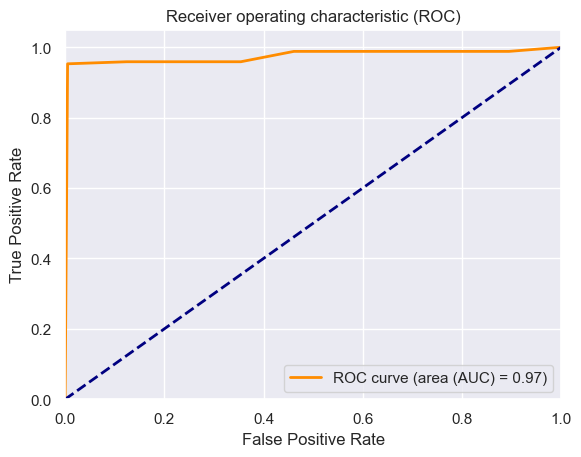

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y, prediction, pos_label=9)
roc_auc = metrics.auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
 lw=lw, label='ROC curve (area (AUC) = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show();

Now we construct a saliency map for our model. Though we are using audio waveforms, the structure of an audio file is similar to that of an image so we can carry out analyses similar to a normal CNN. Below is a saliency map of the first two waveforms in our dataset and the corresponding saliency maps that indicate which parts of the waveforms were most important in terms of influencing the model's ultimate prediction. 

While interpretability here is difficult since the numbers in an audio file have no visual / spatial relationship with each other, we do see that the most dense areas of each spectrogram are often the most influential components. Perhaps this relationship indicates that very brief fluctuations in a sound wave (say, a small peak of volume) are less important compared to sustained sounds, like might occur in a long and intense meow.

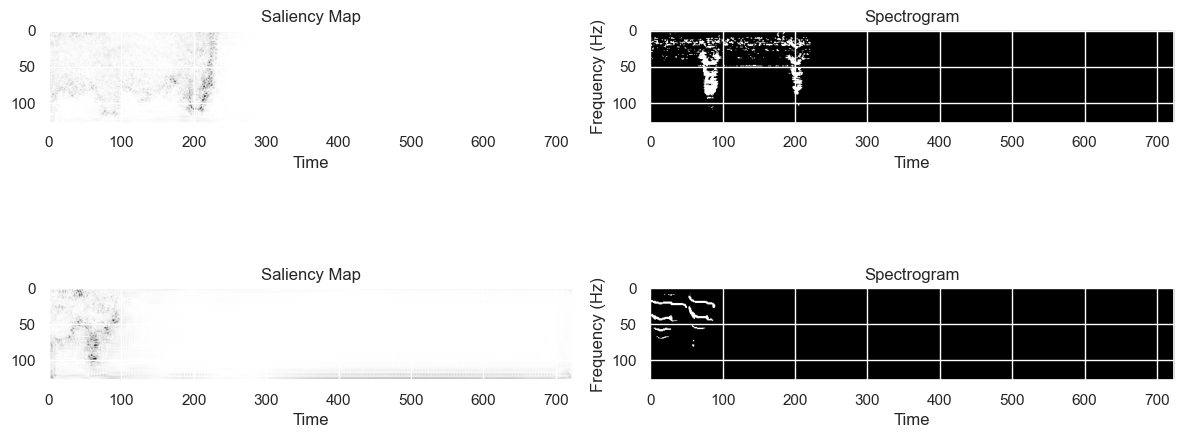

In [36]:


# Example usage:
# Load your trained CNN model
# model = load_model('your_model.h5')

# Assuming input_spec is your audio spectrogram, replace it with your actual spectrogram data
# input_spec = load_spectrogram('your_spectrogram.npy')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for i in range(2):

    # Compute the saliency map
    saliency_map = helpers.compute_saliency_map(best_model, df_numpy.iloc[i]['audio'])

    # Visualize the saliency map
    ax[i][0].imshow(saliency_map[0], cmap='binary')
    ax[i][0].set_title("Saliency Map")
    ax[i][0].set_xlabel("Time")
    ax[i][1].set_ylabel("Frequency (Hz)")
    ax[i][1].imshow(df_numpy.iloc[i]['audio'], cmap='binary')
    ax[i][1].set_title("Spectrogram")
    ax[i][1].set_xlabel("Time")
    ax[i][1].set_ylabel("Frequency (Hz)")

plt.tight_layout();

At this point, we have seen on a broad scale how well our model performs in terms of identifying classes correctly. But are there patterns in terms of which classes are most frequently misclassified? We can analyze these trends via a confusion matrix, as below. Considering our model has a very high accuracy, almost all categories are classified correctly! Interestingly, Happy and Paining are often confused, so perhaps their general wave structure is quite similar. But generally, confusion is very low - exactly as we would desire.

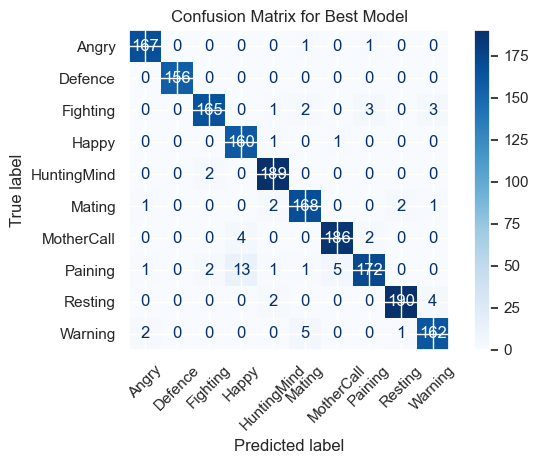

In [37]:
labels = classifications

cm = confusion_matrix(df_numpy['classification'], prediction)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix for Best Model")
plt.tight_layout();
plt.show()

<a id="p5"></a>
    
## Results

[Return to TOC](#contents)

### Conclusions

All four of our models were quite successful, with baseline accuracies of 80% or more on the validation set. 




As expected, the baseline VGG16 model outperformed our baseline CNN, which was entirely untuned and chosen, mostly, from guesswork.  The VGG16 model was pre-trained on a large corpus of data, and we would expect it to perform the bulk of the feature learning necessary – that is, it is able to find alternate representations for our data that could aid in classification.  Our baseline CNN, though, performed quite well, suggesting that the classification task perhaps was not high-complexity.  As a result, we chose to regularize our VGG16 model through early stopping and a linearly decreasing learning rate.  This yielded better results than before.  After successfully achieving a classification accuracy of over 90%, we chose to finally tune the architecture of the last classification layer and dropout layer that we appended to VGG16 and trained.  We found that 512 nodes, which was our original architecture, yielded the best accuracy, combined with a slightly lower dropout of 0.2. 




There were many limitations towards tuning and training our model.  We had extreme difficulties with loading and augmenting the data, which was quite large and required hours to upload or download.  Most of our constraints were related to resources, temporal or computational.  




One could consider tuning a portion of the VGG16 layers rather than unilaterally freezing them, as our group chose to. One could also attempt to optimize our dataset to improve computational time. Thus there are improvements that could be made, but, thankfully, our model performed quite well, and any better would be more granular fine tuning.  







### Strengths and Limitations

Some strengths of the model include using a dropout layer to reduce overfitting, pooling layers to reduce dimensionality, and a high number of trainable parameters to ensure the model is complex enough to capture subtle differences between audio files (though this is both a strength and a weakness).




Other strengths include the use of data augmentation and transfer learning to help the model generalize to sounds other than the exact ones included in the dataset, emphasizing the importance of predictors like pitch with the support of well-trained existing models.






### Future Work

Now that we've explored how to best analyze sound waves within a dataset of simple meows, our next steps would be to extend our analysis to more complex datasets. For instance, how well can we differentiate between the meows of different species of cats, and can we use the same procedure for other animals? 




We might also image further uses for our findings in this project - for instance, could veterinarians use our model to interpret the sounds animals make during procedures? Could cat owners do the same for their pets? We might imagine a number of practical uses for models like these that we'd love to explore more in the future. 




